In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
from lib import data
from lib import sar
from lib import io
from lib import trainer_C
from sklearn.ensemble import RandomForestRegressor
from progressbar import progressbar as pbar


import torchvision.transforms as transforms
import torch
from torch import nn

from lib.model import mlp_cnn
from lib.datamodules import dataset

In [2]:
base_path = "/home/alberto/data/data/RST2/Barcelona"
#date_train = '20100520'
#date_test  = '20120720'

date_test = '20100520'
date_train  = '20120720'

window_size = 7

In [3]:
smtr = io.load_bcn_scatter_matrix(base_path, date_train)
smts = io.load_bcn_scatter_matrix(base_path, date_test)

In [4]:
cmtr = sar.avgpool2D_complex(sar.compute_coherence_matrix(smtr), window_size = window_size)
cmts = sar.avgpool2D_complex(sar.compute_coherence_matrix(smts), window_size = window_size)

In [5]:
smtr.shape, cmtr.shape

((4402, 1602, 2, 2), (628, 228, 3, 3))

## define train/test/val split mask

may use spatial split to attempt to avoid spatial leakage between train, test, val

In [6]:
h, w, _, _ = cmtr.shape

splitmask_random = data.cv_splitpixels_random(h, w, train_pct = .70, test_pct = .15, val_pct = .15)
splitmask_bands  = data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)

TRAIN, TEST, VAL = 0,1,2

In [7]:
cmtr_VV_ampl = (cmtr[:,:,2,2]).real
cmts_VV_ampl = (cmts[:,:,2,2]).real

In [8]:
dset = dataset.ImageMatrixDatset(cmtr[..., 1:3, 1:3], cmtr, splitmask_bands)

In [9]:
len(dset)

102144

In [10]:
dset[1111]

(array([[2996.5178  +0.j    , 1694.8835+659.2363j],
        [1694.8835-659.2365j, 6173.005   +0.j    ]], dtype=complex64),
 array([[5822.854    +0.j     ,  696.519 -1124.7975j ,
         3578.5398-1012.1129j ],
        [ 696.519 +1124.7975j , 2996.5178   +0.j     ,
         1694.8835 +659.2363j ],
        [3578.5398+1012.11163j, 1694.8835 -659.2365j ,
         6173.005    +0.j     ]], dtype=complex64))

In [11]:
getelems_22 = dataset.GetMatrixElements([0,0,1], [0,1,1])
getelems_33 = dataset.GetMatrixElements([0,0,0,1,1,2], [0,1,2,1,2,2])
dset = dataset.ImageMatrixDatset(cmtr, cmtr, splitmask_bands,
                                 transform_in=getelems_22, transform_out=getelems_33)

print(len(dset))
dset[1111]

102144


(array([5822.854    +0.j    ,  696.519 -1124.7975j, 2996.5178   +0.j    ],
       dtype=complex64),
 array([5822.854    +0.j    ,  696.519 -1124.7975j, 3578.5398-1012.1129j,
        2996.5178   +0.j    , 1694.8835 +659.2363j, 6173.005    +0.j    ],
       dtype=complex64))

In [12]:
getelems_22 = dataset.GetMatrixElements_RealAndImag([0,0,1], [0,1,1])
getelems_33 = dataset.GetMatrixElements_RealAndImag([0,0,0,1,1,2], [0,1,2,1,2,2])
dset = dataset.ImageMatrixDatset(cmtr, cmtr, splitmask_bands,
                                 transform_in=getelems_22, transform_out=getelems_33)

print(len(dset))
dset[1111]

102144


(array([ 5822.854 ,   696.519 ,  2996.5178, -1124.7975], dtype=float32),
 array([ 5822.854 ,   696.519 ,  3578.5398,  2996.5178,  1694.8835,
         6173.005 , -1124.7975, -1012.1129,   659.2363], dtype=float32))

# Train MLP - Matrix Log parameters

**input**: $\mathbf{L}_{11}$, $Re(\mathbf{L}_{12})$, $\mathbf{L}_{22}$ and $Im(\mathbf{L}_{12})$ from the matrix logarithm of the 2 by 2 subcovariance matrix corresponding to HV and VV polarizations $\mathbf{L} = \log \mathbf{C}_{22 - 33}$ (4 real values) 

**output**: $\mathbf{L}_{11}$, $Re(\mathbf{L}_{12})$, $Re(\mathbf{L}_{13})$, $\mathbf{L}_{22}$, $Re(\mathbf{L}_{23})$, $\mathbf{L}_{33}$, $Im(\mathbf{L}_{12})$, $Im(\mathbf{L}_{13})$ and $Im(\mathbf{L}_{23})$ from the matrix logarithm of the 3 by 3 full-pol covariance matrix $\mathbf{L} = \log \mathbf{C}$ (9 real values)

**loss**: Here the loss will be the Mean Squared Error (MSE) over the elements in the log space.

**Note**: Since the matrix logarithm depends on the whole covariance matrix, it is not the same to perform the logarithm of the 3x3 covariance matrix and take the 2x2 submatrix than doing the logarithm of the 2x2 submatrix

In [13]:
lcmtr = sar.matlog(cmtr)
lcmts = sar.matlog(cmts)
lcmtr2 = sar.matlog(cmtr[...,1:3, 1:3])
lcmts2 = sar.matlog(cmts[...,1:3, 1:3])
lcmtr.shape, lcmtr2.shape

((628, 228, 3, 3), (628, 228, 2, 2))

In [14]:
lcmtr_VV_ampl = (lcmtr[:,:,2,2]).real
lcmts_VV_ampl = (lcmts[:,:,2,2]).real

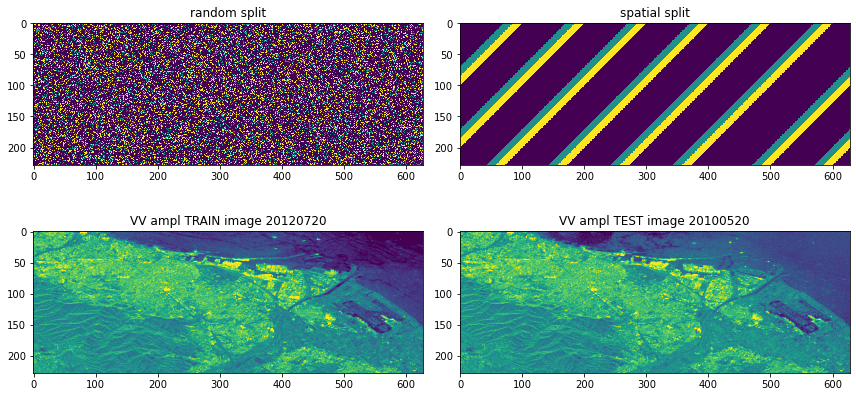

In [15]:
a,b = np.percentile(list(lcmtr_VV_ampl.flatten()) + list(lcmts_VV_ampl.flatten()), [1,99])

for ax, i in subplots(4, usizex=6, n_cols=2):
    if i==0: plt.imshow(splitmask_random.T, interpolation='none'); plt.title("random split")
    if i==1: plt.imshow(splitmask_bands.T, interpolation='none'); plt.title("spatial split")
    if i==2: plt.imshow(lcmtr_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TRAIN image {date_train}") 
    if i==3: plt.imshow(lcmts_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TEST image {date_test}") 

In [16]:
# Indices upper triangular matrix for 2x2 and 3x3 matrices
c2tri_x1, c2tri_x2 = np.triu_indices(2)
c3tri_x1, c3tri_x2 = np.triu_indices(3)

transforms_in = transforms.Compose([
    dataset.GetMatrixElements_RealAndImag(c2tri_x1, c2tri_x2),
    #dataset.GetMatrixElements_RealAndImag([0,0,1], [0,1,1]),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transforms_out = transforms.Compose([
    dataset.GetMatrixElements_RealAndImag(c3tri_x1, c3tri_x2),
    #dataset.GetMatrixElements_RealAndImag([0,0,0,1,1,2], [0,1,2,1,2,2]),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

dset_tr = dataset.ImageMatrixDatset(lcmtr2, lcmtr, splitmask_bands,
                                    transform_in=transforms_in,
                                    transform_out=transforms_out,
                                    split="train")
dset_ts = dataset.ImageMatrixDatset(lcmts2, lcmts, splitmask_bands,
                                    transform_in=transforms_in,
                                    transform_out=transforms_out,
                                    split="test")
print(f"Length of training dataset: {len(dset_tr)}")
print(f"Length of test dataset: {len(dset_ts)}")

Length of training dataset: 102144
Length of test dataset: 20520


In [17]:
batch_size = 256
num_workers = 2

# Create the dataloader
dataloader_tr = torch.utils.data.DataLoader(dset_tr, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
dataloader_ts = torch.utils.data.DataLoader(dset_ts, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# Decide which device we want to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Test to get some training samples
batch_in, batch_out = next(iter(dataloader_ts))
print(batch_in.shape)
print(batch_out.shape)
print(len(dataloader_ts))

torch.Size([256, 4])
torch.Size([256, 9])
81


In [19]:
# Define the model
N_hiden_layers = 3
Hiden_size = 64

#model = mlp_cnn.MLP(4,9, [Hiden_size] * N_hiden_layers)
model = mlp_cnn.MLP(4,9, [Hiden_size] * N_hiden_layers, normalization=nn.BatchNorm1d)
#model = mlp_cnn.MLP(4,9, [Hiden_size] * N_hiden_layers, normalization=nn.BatchNorm1d, activation=nn.GELU)
model = model.to(device)
print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=False)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=9, bias=True)
  )
)


In [20]:
# Define loss function
loss_fn = nn.MSELoss()


In [21]:
# Define optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())

In [22]:
def train_one_epoch(training_loader):
    running_loss = 0.
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, desired_output = data

        # Move data to device
        inputs = inputs.to(device)
        desired_output = desired_output.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, desired_output)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    
    return running_loss / len(training_loader)

def evaluate_test(test_loader):
    running_loss = 0.
    model.eval()
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(test_loader):
        # Every data instance is an input + output pair
        inputs, desired_output = data

        # Move data to device
        inputs = inputs.to(device)
        desired_output = desired_output.to(device)

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, desired_output)

        # Gather data and report
        running_loss += loss.item()
    
    return running_loss / len(test_loader)


In [23]:
N_epochs = 200

losses_train = []
losses_test = []
for i in pbar(range(N_epochs)):
    # Train
    avg_loss = train_one_epoch(dataloader_tr)
    losses_train.append(avg_loss)
    # Test
    avg_loss = evaluate_test(dataloader_ts)
    losses_test.append(avg_loss)
    

100% (200 of 200) |######################| Elapsed Time: 0:06:08 Time:  0:06:080329


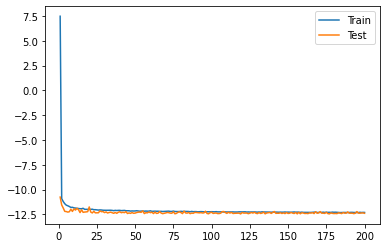

In [24]:
plt.figure()
plt.plot(np.arange(1, N_epochs+1), 10*np.log10(losses_train), label="Train")
plt.plot(np.arange(1, N_epochs+1), 10*np.log10(losses_test), label="Test")
plt.legend()

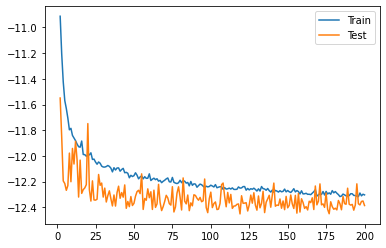

In [25]:
plt.figure()
plt.plot(np.arange(2, N_epochs+1), 10*np.log10(losses_train[1:]), label="Train")
plt.plot(np.arange(2, N_epochs+1), 10*np.log10(losses_test[1:]), label="Test")
plt.legend()

In [26]:
def train_model(model, N_epochs):
    
    losses_train = []
    losses_test = []
    for i in pbar(range(N_epochs)):
        # Train
        avg_loss = train_one_epoch(dataloader_tr)
        losses_train.append(avg_loss)
        # Test
        avg_loss = evaluate_test(dataloader_ts)
        losses_test.append(avg_loss)
    return losses_train, losses_test

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 1 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:02:23 Time:  0:02:230113


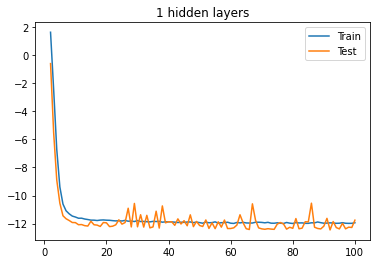

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 2 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:02:14 Time:  0:02:140112


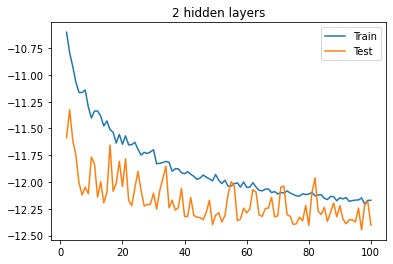

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 3 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:02:16 Time:  0:02:160112


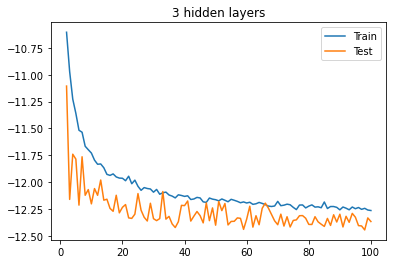

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 4 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:02:20 Time:  0:02:200112


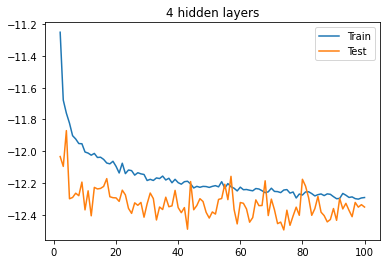

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 5 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:02:25 Time:  0:02:250113


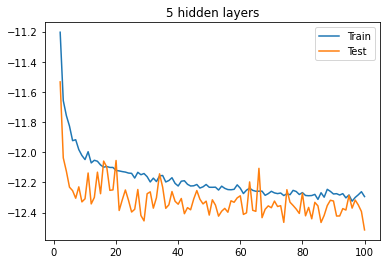

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 6 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:02:34 Time:  0:02:340113


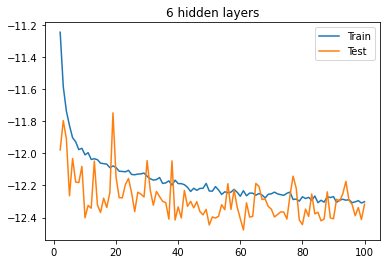

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 7 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:02:42 Time:  0:02:420114


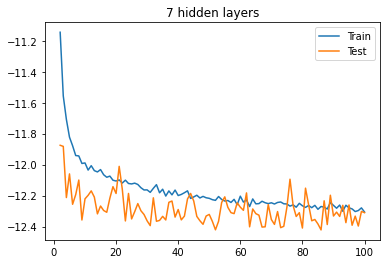

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 8 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:02:56 Time:  0:02:560115


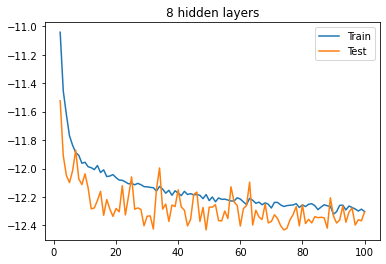

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 9 hidden layers...


100% (100 of 100) |######################| Elapsed Time: 0:03:09 Time:  0:03:090117


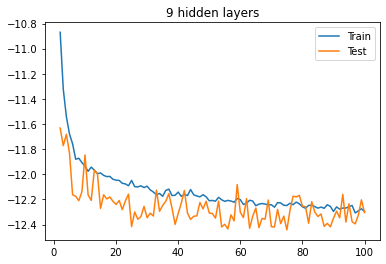

In [27]:
# Test increasing number of layers
llosses_train = []
llosses_test = []
for hlayers in range(1,10):
    model = mlp_cnn.MLP(4,9, [Hiden_size] * hlayers, normalization=nn.BatchNorm1d)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    print(f"Training model with {hlayers} hidden layers...")
    losses_train, losses_test = train_model(model, 100)
    llosses_train.append(losses_train)
    llosses_test.append(losses_test)
    plt.figure()
    plt.plot(np.arange(2, 100+1), 10*np.log10(losses_train[1:]), label="Train")
    plt.plot(np.arange(2, 100+1), 10*np.log10(losses_test[1:]), label="Test")
    plt.legend()
    plt.title(f"{hlayers} hidden layers")
    plt.show()

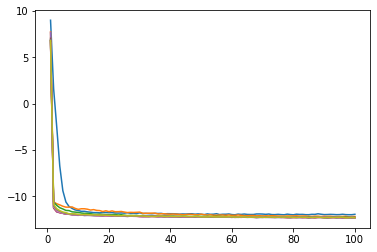

In [28]:
plt.figure()
plt.plot(np.arange(1, 101), 10*np.log10(llosses_train).T, label="Train")

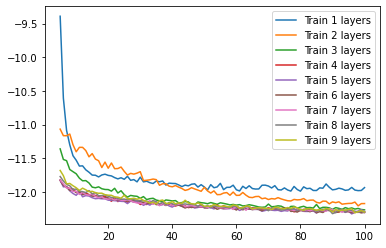

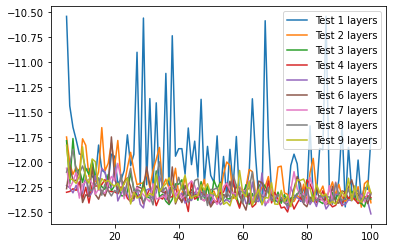

In [29]:
plt.figure()
for i, losses_train in enumerate(llosses_train):
    plt.plot(np.arange(5, 101), 10*np.log10(losses_train)[4:], label=f"Train {i+1} layers")
plt.legend()

plt.figure()
for i, losses_train in enumerate(llosses_train):
    #plt.plot(np.arange(5, 101), 10*np.log10(losses_train)[4:], label=f"Train {i+1} layers")
    losses_test = llosses_test[i]
    plt.plot(np.arange(5, 101), 10*np.log10(losses_test)[4:], label=f"Test {i+1} layers")
plt.legend()

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 16 hidden neurons (*4 layers)...


100% (100 of 100) |######################| Elapsed Time: 0:02:20 Time:  0:02:200112


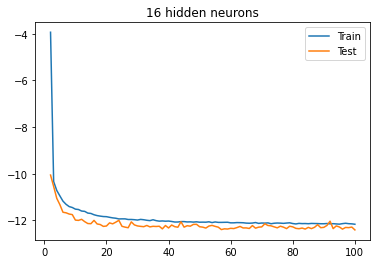

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 32 hidden neurons (*4 layers)...


100% (100 of 100) |######################| Elapsed Time: 0:02:20 Time:  0:02:200112


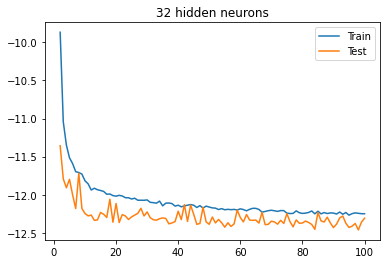

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 64 hidden neurons (*4 layers)...


100% (100 of 100) |######################| Elapsed Time: 0:02:19 Time:  0:02:190112


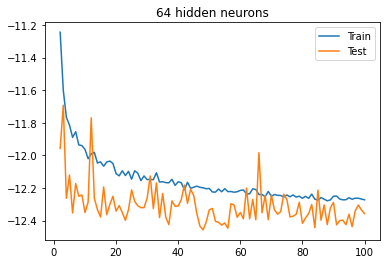

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 128 hidden neurons (*4 layers)...


100% (100 of 100) |######################| Elapsed Time: 0:02:21 Time:  0:02:210112


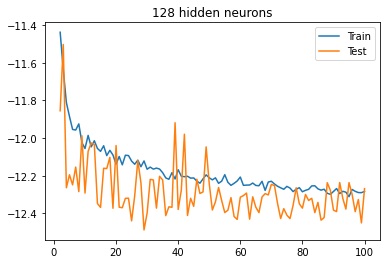

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 256 hidden neurons (*4 layers)...


100% (100 of 100) |######################| Elapsed Time: 0:02:21 Time:  0:02:210112


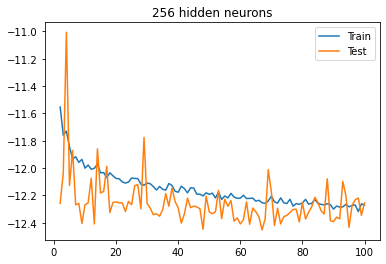

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 512 hidden neurons (*4 layers)...


100% (100 of 100) |######################| Elapsed Time: 0:02:29 Time:  0:02:290113


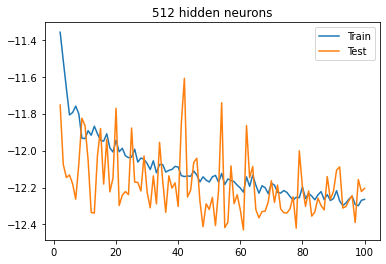

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training model with 1024 hidden neurons (*4 layers)...


100% (100 of 100) |######################| Elapsed Time: 0:03:21 Time:  0:03:210218


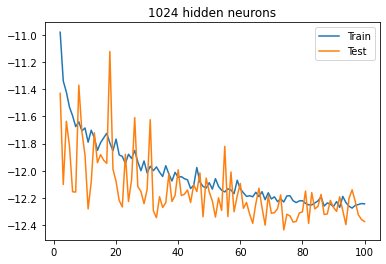

In [30]:
# Test increasing hiden layers neurons
N_hiden_layers = 4
llosses_train = []
llosses_test = []

values_hiden_neurons = [16, 32, 64, 128, 256, 512, 1024]

for hsize in values_hiden_neurons:
    model = mlp_cnn.MLP(4,9, [hsize] * N_hiden_layers, normalization=nn.BatchNorm1d)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    print(f"Training model with {hsize} hidden neurons (*4 layers)...")
    losses_train, losses_test = train_model(model, 100)
    llosses_train.append(losses_train)
    llosses_test.append(losses_test)
    plt.figure()
    plt.plot(np.arange(2, 100+1), 10*np.log10(losses_train[1:]), label="Train")
    plt.plot(np.arange(2, 100+1), 10*np.log10(losses_test[1:]), label="Test")
    plt.legend()
    plt.title(f"{hsize} hidden neurons")
    plt.show()

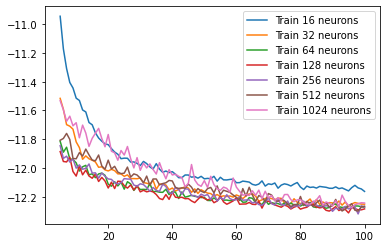

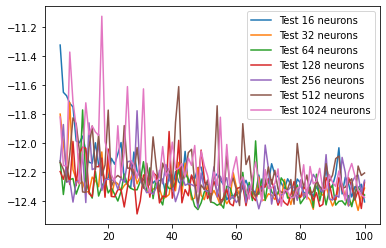

In [31]:
plt.figure()
for i, losses_train in enumerate(llosses_train):
    plt.plot(np.arange(5, 101), 10*np.log10(losses_train)[4:], label=f"Train {values_hiden_neurons[i]} neurons")
plt.legend()

plt.figure()
for i, losses_train in enumerate(llosses_train):
    #plt.plot(np.arange(5, 101), 10*np.log10(losses_train)[4:], label=f"Train {i+1} layers")
    losses_test = llosses_test[i]
    plt.plot(np.arange(5, 101), 10*np.log10(losses_test)[4:], label=f"Test {values_hiden_neurons[i]} neurons")
plt.legend()